In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
survey_file = '../data/survey_responses.tsv'
survey = pd.read_csv(survey_file, sep='\t')

codes_file = '../data/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')
adid_codes = dict(zip(codes['adid'], [r.split(';') for r in codes['codes']]))

pid_adid_files = [f'../data/surveys/survey-{n}/survey{n}_coding_subsample.tsv'
                 for n in range(1, 8)]
pid_adid_files.append('../data/surveys/survey-1/pid_adid_survey1_batch2.tsv')
pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)

print('pid_adid:', pid_adid.shape)
print('survey:', survey.shape)
    
part_ad_counts = pid_adid.groupby('pid').count().to_dict()['adid']

pid_adid: (39564, 2)
survey: (7837, 5)


In [3]:
short_names = {
    # dislike
    "I do not dislike this ad.": "dont-dislike",
    "I cannot tell what is being advertised.": "unclear",
    "It is irrelevant to me, or doesn’t contain interesting information.": "irrelevant",
    "I find the ad pushy or it causes me to feel anxious.": "pushy",
    "It contains clickbait, sensationalized, or shocking content.": "clickbait",
    "I do not trust this ad, it seems like a scam.": "scam",
    "I dislike the type of product being advertised.": "dislike-product",
    "I do not like the design of the ad.": "dislike-design",
    "I find the content uncomfortable, offensive, or repulsive.": "uncomfortable",    
    "I dislike the advertiser.": "dislike-advertiser",
    "I dislike the political nature of the ad.": "political",
    # like
    "The content is engaging, clever or amusing.": "amusing",
    "It is well designed or eye-catching.": "like-design",
    "I am interested in what is being advertised.": "interested",
    "It is clear what product the ad is selling.": "clear",
    "I trust the ad, it looks authentic or trustworthy.": "trust-ad",
    "I trust the advertiser.": "trust-advertiser",
    "It is useful, interesting, or informative.": "useful",
    "It clearly looks like an ad and can be filtered out.": "filterable",
    "I do not like this ad.": "dont-like"
}

like_list = ["amusing", "like-design", "interested", "clear", "trust-ad",
     "trust-advertiser", "useful", "filterable", "dont-like"]
dislike_list = ["dont-dislike", "unclear", "irrelevant", "pushy", "clickbait",
    "scam", "dislike-product", "dislike-design", "uncomfortable",
    "dislike-advertiser", "political"]

# actual reasons for liking or disliking
like_reasons = set(like_list) - set(["dont-like"])
dislike_reasons = set(dislike_list) - set(["dont-dislike"])

In [4]:
survey_codes = survey.merge(codes, 'inner', 'adid')

perceptions = defaultdict(list)  # perceptions by code
survey_code_counts = Counter()   # number of times each code appeared in survey

In [ ]:
# Piotr starts trying PCA
binary_likes = []
binary_dislikes = []
binary_labels = []
for idx, row in survey_codes.iterrows():
    binary_likes.append({item: 1 for item in row['like'].split(';')})
    binary_dislikes.append({item: 1 for item in row['dislike'].split(';')})
    binary_labels.append({item: 1 for item in row['codes'].split(';')})
    
    
    

In [12]:
dislikesdf = pd.DataFrame(binary_dislikes)
dislikesdf.fillna(0, inplace=True)
dislikesdf -= np.mean(dislikesdf, axis=0)
dislikesdf /= np.std(dislikesdf, axis=0)

In [72]:
from sklearn.decomposition import PCA
pca_dislikes = PCA(n_components=11)
components = pca_dislikes.fit_transform(dislikesdf)

In [73]:
labelsdf = pd.DataFrame(binary_labels)
labelsdf.fillna(0, inplace=True)

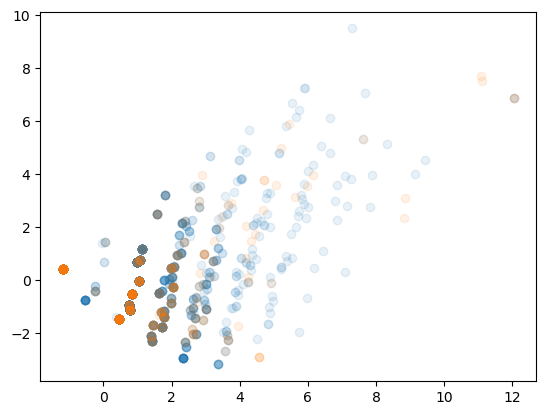

In [74]:
f, ax = plt.subplots()
for label in labelsdf.columns:
    if label in ['Benign', 'Clickbait']:
        idx = labelsdf[label]==1
        ax.scatter(components[idx, 0], components[idx, 1], label=label, alpha=0.1)
#ax.legend()

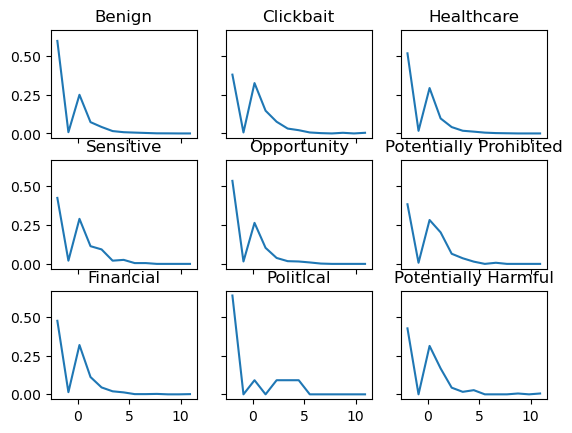

In [75]:
# y, x = np.histogram(components[labelsdf['Benign']==1])
                               


# plt.hist(components[labelsdf['Clickbait']==1, 1])
# plt.hist(components[labelsdf['Sensitive']==1, 1])

f, axes = plt.subplots(3, 3, sharex= True, sharey=True)

for idx, label in enumerate(labelsdf.columns[:9]):
    y, x =  np.histogram(components[labelsdf[label]==1, 0], bins = np.linspace(-2, 12, 14))
    axes[idx // 3, idx % 3].plot(x[:-1], y/np.sum(y))
    axes[idx // 3, idx % 3].set_title(label)
    

In [76]:
labelsdf.columns

Index(['Benign', 'Clickbait', 'Healthcare', 'Sensitive', 'Opportunity',
       'Potentially Prohibited', 'Financial', 'Political',
       'Potentially Harmful', 'Can't determine, return to this one', 'Study',
       'CA Lawsuit'],
      dtype='object')

In [77]:
dislikesdf.std()

It contains clickbait, sensationalized, or shocking content.           1.000064
I do not trust this ad, it seems like a scam.                          1.000064
I cannot tell what is being advertised.                                1.000064
I do not dislike this ad.                                              1.000064
It is irrelevant to me, or doesn’t contain interesting information.    1.000064
I find the ad pushy or it causes me to feel anxious.                   1.000064
I do not like the design of the ad.                                    1.000064
I dislike the type of product being advertised.                        1.000064
I find the content uncomfortable, offensive, or repulsive.             1.000064
I dislike the advertiser.                                              1.000064
I dislike the political nature of the ad.                              1.000064
dtype: float64

In [78]:
pca_dislikes.components_[1]

array([ 0.06473248, -0.0753214 , -0.23767667,  0.35228999, -0.47496723,
        0.22477577, -0.1815022 ,  0.23215832,  0.42011085,  0.30206422,
        0.4228989 ])

In [79]:
components[label]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [110]:
for componentid in range(0, 11):
    print(componentid)
    for idx in np.argsort(np.abs(pca_dislikes.components_[componentid]))[::-1]:
        print(dislikesdf.columns[idx], pca_dislikes.components_[componentid, idx])
    for label in labelsdf.columns:
        print(label, components[labelsdf[label]==1, componentid].mean())
    print()
        

0
I do not dislike this ad. -0.5026172493860469
I do not trust this ad, it seems like a scam. 0.32238258510245743
It contains clickbait, sensationalized, or shocking content. 0.2924397078271408
I dislike the type of product being advertised. 0.27651435687294823
I dislike the advertiser. 0.2709505557877859
I cannot tell what is being advertised. 0.2701627236584868
I find the ad pushy or it causes me to feel anxious. 0.2694813746916635
I find the content uncomfortable, offensive, or repulsive. 0.2628738997832947
I do not like the design of the ad. 0.26268476563357146
It is irrelevant to me, or doesn’t contain interesting information. 0.2599791731674674
I dislike the political nature of the ad. 0.23821574499874115
Benign -0.12002980542256089
Clickbait 0.6574805384135249
Healthcare 0.03297811236135172
Sensitive 0.45014292491120905
Opportunity 0.0334196867208486
Potentially Prohibited 0.4920391482073515
Financial 0.19259317341302756
Political 0.4194335173164564
Potentially Harmful 0.4438664

In [62]:
components[labelsdf['Benign']==1, 1].mean()

0.051933739729854114

In [82]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()


In [96]:
y = []
for idx, row in labelsdf.iterrows():
    added=False
    for vidx, v in enumerate(row.values[:9]):
        if v:
            y.append(vidx)
            added = True
            break
    if not added:
        y.append(-1)

In [98]:
clf.fit(components, y)

RandomForestClassifier()

In [99]:
y_pred = clf.predict(components)

In [100]:
y_true = np.array(y)

In [101]:
np.sum(y_pred == y_true)/len(y)

0.5183105780273064

In [103]:
np.sum(y_pred)

937

In [106]:
(y_pred[y_pred != 0] - y_true[y_pred != 0] == 0).mean()

0.6026666666666667

In [109]:
components.var(axis=0)

array([2.62099116, 1.26110517, 1.09763652, 1.00039566, 0.89898096,
       0.85146116, 0.79143926, 0.77219124, 0.74513382, 0.70093526,
       0.2597298 ])